## Comparison between next token prediction (NTP) and multi-token prediction (MTP)

Let true dist $p$ satisfy 
$$p(y_1| x) = \sigma(W_a x)$$
$$p(y_1, y_2| x) = \sigma(W_a x) \sigma(W_a x)^\top$$ 

We then compare fitting $\widehat{W}_a$ using two either of the two objectives:

- $l^{(ntp)}(\theta) = \sum_{x,y_1} -\log \sigma(\widehat{W}_a x)$ 
- $l^{(mtp)}(\theta) =  \sum_{x,y_1, y_2} -\log \sigma(\widehat{W}_a x)_{y_1}  + -\log \sigma(\widehat{W}_a x)_{y_1} \sigma(\widehat{W}_a x)_{y_2}$

In [408]:
import torch
from typing import Optional
from dataclasses import dataclass
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [418]:
# Set seed
torch.manual_seed(42)

# HPs
lr = 1e-3
batch_size = 32
n_epochs = 10_000
eval_every = 1000
d_model, d_vocab = 32, 32
mode = 'full_rank'

# True model: maps x -> e1 ident dist)
# Rank 1 model:
w_alpha = torch.zeros(d_vocab, d_model)
w_alpha[0] = 1

# Full rank model:
# w_alpha = torch.eye(d_vocab, d_model)

def get_samples(x, w, horizon=1):
  # Return samples from p(y1, y2, ..., yH | x, w)
  # x: (B, D), w: (V, D)
  py_h_bar_x = torch.softmax(torch.einsum('bd, vd->bv', x, w), dim=-1)
  # y = torch.multinomial(py_h_bar_x, num_samples=horizon) # (B, H)
  y =torch.cat([torch.multinomial(py_h_bar_x, num_samples=1) for _ in range(horizon)], dim=-1)
  return y

In [419]:
@dataclass
class ModelOutput:
  logits: torch.Tensor
  loss: Optional[torch.Tensor] = None
  loss_dict: Optional[dict] = None

In [420]:
from mtp.mheads import MHEADS

class JointModel(torch.nn.Module):
  def __init__(self, d_model, d_vocab, lam=0.0):
    super().__init__()
    self.w_alpha_hat = torch.nn.Linear(d_model, d_vocab, bias=False)
    self.lam = lam

  def get_ntp_logits(self, x):
    return self.w_alpha_hat(x)  # (B, D) -> (B, V)

  def get_aux_loss(self, x, y):
    # y: (B, H)
    B, H = y.shape
    loss_aux = 0
    for h in range(H):
      logits = self.w_alpha_hat(x) # B,D -> B,V
      loss_aux += torch.nn.functional.cross_entropy(logits, y[:, h])
    return loss_aux

  def forward(self, x, y=None):
    """
      Args:
        x: Input features. Shape: (B, D)
        y: Targets. Shape (B, H)
    """
    loss = None
    logits = self.get_ntp_logits(x) # B,D -> B,V
    loss_dict = {}
    if y is not None:
      loss_main = torch.nn.functional.cross_entropy(logits, y[:, 0])
      loss_aux = self.get_aux_loss(x, y)*self.lam if self.lam > 0 else 0
      loss = loss_main + loss_aux
      loss_dict = {'loss_main': loss_main, 'loss_aux': loss_aux}
    return ModelOutput(loss=loss, logits=logits, loss_dict=loss_dict)

  def forward2(self, x, y=None):
    """
      Args:
        x: Input features. Shape: (B, D)
        y: Targets. Shape (B, H)
    """
    loss = None
    logits = self.w_alpha_hat(x) # B,D -> B,V
    loss_dict = {}
    if y is not None:
      loss = torch.nn.functional.cross_entropy(logits, y[:, 0])
      loss_dict['loss_main'] = loss
    return ModelOutput(loss=loss, logits=logits, loss_dict=loss_dict)


# class JointModelV2(torch.nn.Module):
#   def __init__(self, d_model, d_vocab, rank=2, lam=0.0):
#     super().__init__()
#     self.w_alpha_hat = torch.nn.Linear(d_model, d_vocab*rank*2, bias=False)
#     self.lam = lam
#     self.rank = rank

#   def get_ntp_logits(self, x):
#     zs = self.w_alpha_hat(x).reshape(x.shape[0], d_vocab, 2, self.rank)  # (B, D) -> (B, V, 2, R)
#     res = 0
#     for r in range(self.rank):
#       res += torch.einsum('bvr,vrd->bvr', zs[:, :, :, r], self.w_alpha_hat.weight[:, :, r])
#     return res

#   def get_aux_loss(self, x, y):
#     # y: (B, H)
#     B, H = y.shape
#     loss_aux = 0
#     for h in range(H):
#       logits = self.w_alpha_hat(x) # B,D -> B,V
#       loss_aux += torch.nn.functional.cross_entropy(logits, y[:, h])
#     return loss_aux

#   def forward(self, x, y=None):
#     """
#       Args:
#         x: Input features. Shape: (B, D)
#         y: Targets. Shape (B, H)
#     """
#     loss = None
#     logits = self.get_ntp_logits(x) # B,D -> B,V
#     loss_dict = {}
#     if y is not None:
#       loss_main = torch.nn.functional.cross_entropy(logits, y[:, 0])
#       loss_aux = self.get_aux_loss(x, y)*self.lam if self.lam > 0 else 0
#       loss = loss_main + loss_aux
#       loss_dict = {'loss_main': loss_main, 'loss_aux': loss_aux}
#     return ModelOutput(loss=loss, logits=logits, loss_dict=loss_dict)

#   def forward2(self, x, y=None):
#     """
#       Args:
#         x: Input features. Shape: (B, D)
#         y: Targets. Shape (B, H)
#     """
#     loss = None
#     logits = self.w_alpha_hat(x) # B,D -> B,V
#     loss_dict = {}
#     if y is not None:
#       loss = torch.nn.functional.cross_entropy(logits, y[:, 0])
#       loss_dict['loss_main'] = loss
#     return ModelOutput(loss=loss, logits=logits, loss_dict=loss_dict)



In [421]:
def run_train(models, batch_size, d_model, d_vocab, n_epochs, eval_every, lr, X=None):

    for m in models:
        # Define an optimizer
        optimizer = optim.AdamW(m['model'].parameters(), lr=lr)

        # Training loop (minimal example)
        for epoch in range(n_epochs): # train for 10 epochs
            optimizer.zero_grad()

            # sample from true model
            if X is None:
                X = torch.randn(batch_size, d_model)
            else:
                indices = torch.randperm(X.shape[0])[:batch_size]
                X = X[indices]
            y = m['sample_fn'](X, w_alpha) # (B, H)

            output = m['model'](X, y) # Forward pass
            loss = output.loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights

            if (epoch + 1) % eval_every == 0:
                X = torch.randn(1000, d_model)
                y = m['sample_fn'](X, w_alpha) # (B, H)
                output = m['model'](X, y) # Forward pass
                acc = torch.softmax(output.logits, dim=-1).argmax(dim=-1) == y.argmax(dim=-1)
                acc = acc.sum() / len(acc)
                m['eval/accuracy'].append(acc.item())
                m['eval/loss'].append(output.loss_dict['loss_main'].item())


    return models

In [422]:
# IMPORTANT: This cell runs HPO and can be skipped. Best HPs are:
# [main] LR: 0.001 | Max acc: 0.49
# [aux] LR: 0.001, LAM: 0.1 | Max acc: 0.40

# # HPO:
# for lr in [1e-3, 1e-4, 1e-5]:
#     models = [
#         {
#             "name": "main", 
#             "model": ConditionalModel(d_model, d_vocab), 
#             "sample_fn": lambda x, w: get_samples(x, w, horizon=1), 
#             "eval/accuracy": [],
#             "eval/loss": [],
#         },
#     ]

#     run_train(models[:1], batch_size, d_model, d_vocab, n_epochs, eval_every, lr)
#     print(f"[main] LR: {lr} | Max acc: {max(models[0]['eval/accuracy']):.2f}")

# for lr, lam in itertools.product([1e-3, 1e-4, 1e-5], [0, 0.1, 0.5, 1]):
#     models = [
#         {
#             "name": "aux", 
#             "model": JointModel(d_model, d_vocab, lam=lam),
#             "sample_fn": lambda x, w: get_samples(x, w, horizon=2), 
#             "eval/accuracy": [],
#             "eval/loss": [],
#         }
#     ]
#     run_train(models[:1], batch_size, d_model, d_vocab, n_epochs, eval_every, lr)
#     print(f"[aux] LR: {lr}, LAM: {lam} | Max acc: {max(models[0]['eval/accuracy']):.2f}")


### Infinite data setting

In [423]:
# Best HPs:
# [main] LR: 0.001 | Max acc: 0.49
# [aux] LR: 0.001, LAM: 0.1 | Max acc: 0.40
models = [
    {
        "name": "main", 
        "model": JointModel(d_model, d_vocab), 
        "sample_fn": lambda x, w: get_samples(x, w, horizon=1), 
        "eval/accuracy": [],
        "eval/loss": [],
    },
    {
        "name": "aux", 
        "model": JointModel(d_model, d_vocab, lam=0.1),
        "sample_fn": lambda x, w: get_samples(x, w, horizon=2), 
        "eval/accuracy": [],
        "eval/loss": [],
    }
]
# Start from same init for w_alpha_hat
w_alpha_hat = torch.randn(d_vocab, d_model)
for m in models:
    print(f"Setting w_alpha_hat for {m['name']}")
    m['model'].w_alpha_hat.weight.data = w_alpha_hat.clone().detach()
models = run_train(models, batch_size, d_model, d_vocab, n_epochs, eval_every, lr=1e-3)

Setting w_alpha_hat for main
Setting w_alpha_hat for aux


In [424]:
dfs = []
for m in models:
    print(m['name'])
    df_i = pd.DataFrame({'epoch': range(len(m['eval/accuracy'])), 'eval/accuracy': m['eval/accuracy'], 'eval/loss': m['eval/loss'], 'name': m['name']})
    dfs.append(df_i)    
df = pd.concat(dfs)

main
aux


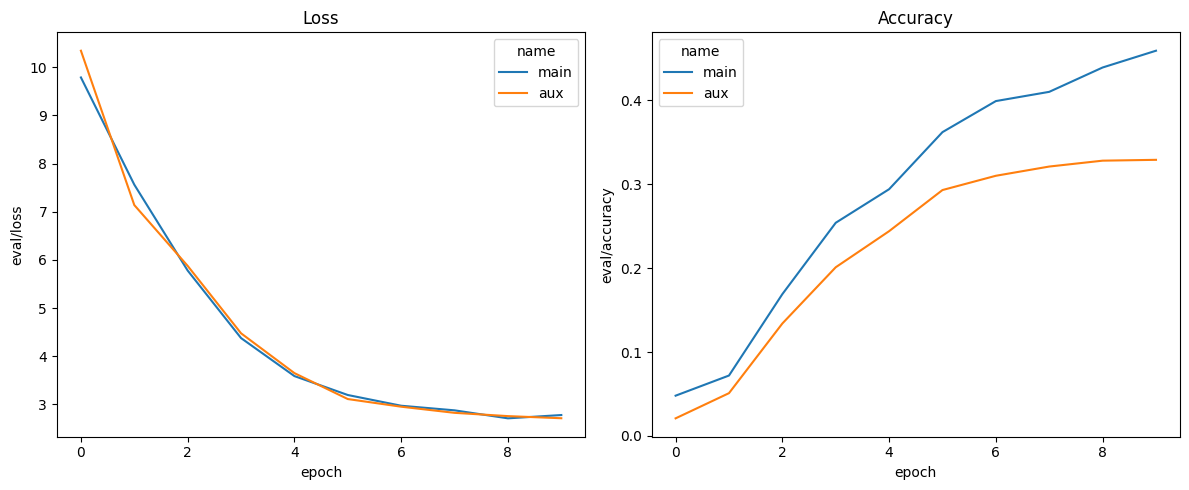

<Figure size 640x480 with 0 Axes>

In [425]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

sns.lineplot(data=df, x="epoch", y="eval/loss", hue="name", ax=axes[0])
axes[0].set_title("Loss")

sns.lineplot(data=df, x="epoch", y="eval/accuracy", hue="name", ax=axes[1])
axes[1].set_title("Accuracy")

plt.tight_layout()
plt.show()
# save figure
plt.savefig(f'mtp_analysis_{mode}.png')



### Limited data setting

In [426]:
# Best HPs:
# [main] LR: 0.001 | Max acc: 0.49
# [aux] LR: 0.001, LAM: 0.1 | Max acc: 0.40
models = [
    {
        "name": "main", 
        "model": ConditionalModel(d_model, d_vocab), 
        "sample_fn": lambda x, w: get_samples(x, w, horizon=1), 
        "eval/accuracy": [],
        "eval/loss": [],
        "eval/best_accs": [],
        "n_samples": [],
    },
    {
        "name": "aux", 
        "model": JointModel(d_model, d_vocab, lam=0.1),
        "sample_fn": lambda x, w: get_samples(x, w, horizon=2), 
        "eval/accuracy": [],
        "eval/loss": [],
        "eval/best_accs": [],
        "n_samples": [],
    }
]
for n_samples in [10, 100, 1000]:
    X = torch.randn(n_samples, d_model)
    # Start from same init for w_alpha_hat
    w_alpha_hat = torch.randn(d_vocab, d_model)
    for m in models:
        print(f"Setting w_alpha_hat for {m['name']}")
        m['model'].w_alpha_hat.weight.data = w_alpha_hat.clone().detach()

    # Run training
    models = run_train(models, batch_size, d_model, d_vocab, n_epochs, eval_every, lr=1e-3, X=X)

    # Add best accuracy 
    for m in models:
        m['eval/best_accs'].append(max(m['eval/accuracy']))
        m['n_samples'].append(n_samples)


Setting w_alpha_hat for main
Setting w_alpha_hat for aux
Setting w_alpha_hat for main
Setting w_alpha_hat for aux
Setting w_alpha_hat for main
Setting w_alpha_hat for aux
